# Do I understand how responses work?

I don't think I do, because I can't make the flux models match up. So let's figure this out!

In [26]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import astropy.io.fits as fits
import sherpa.astro.ui as ui

First, let's load the fake0 spectrum that Victoria gave me. At the moment, I'm only using the first order of the HEG spectrum, so we're only going to load that:

In [2]:
datadir = "/Users/danielahuppenkothen/work/repositories/shiftylines/data/cygx1_sims/"

ui.load_data(id="f0_heg_p1", filename=datadir+"fake_heg_p1_5ks_ident0_src.pha")
#sherpa.astro.ui.load_data(id="f0_heg_m1", filename=datadir+"fake_heg_m1_5ks_ident0_src.pha")
#sherpa.astro.ui.load_data(id="f0_meg_p1", filename=datadir+"fake_meg_p1_5ks_ident0_src.pha")
#sherpa.astro.ui.load_data(id="f0_meg_m1", filename=datadir+"fake_meg_m1_5ks_ident0_src.pha")

statistical errors were found in file '/Users/danielahuppenkothen/work/repositories/shiftylines/data/cygx1_sims/fake_heg_p1_5ks_ident0_src.pha' 
but not used; to use them, re-read with use_errors=True
read ARF file /Users/danielahuppenkothen/work/repositories/shiftylines/data/cygx1_sims/heg_p1.arf
read RMF file /Users/danielahuppenkothen/work/repositories/shiftylines/data/cygx1_sims/heg_p1.rmf


We'll also need the lines (note: they're in Angstrom!):

In [3]:
lines = np.loadtxt("../data/si_lines.txt")

To convert to keV, let's use a simple conversion factor:

In [4]:
c = 12.3984191
lines_kev = c/lines

Let's load the data into an actual variable so we can play around with it:

In [5]:
d = ui.get_data("f0_heg_p1")

We're only looking at a small part of the spectrum, so we want to cut out that part:

In [6]:
min_e = 6.0499997575723086
max_e = 7.100000097785645

# same in keV, because that's what our spectrum is in!
min_kev = c/max_e
max_kev = c/min_e

We need
* the bin edges (low and high)
* the counts 
* the arf

In [15]:
# sorted indices
idx_heg = d.bin_lo.argsort()

# the low bin edges
bin_lo = d.bin_lo[idx_heg]
# the upper bin edges
bin_hi = d.bin_hi[idx_heg]
# the counts array
counts = d.counts[idx_heg]

# Let's also make the mid-points for plotting
bin_mid = bin_lo + (bin_hi - bin_lo)/2.0

Now we can to cut out the parts of the spectrum we actually need:

In [16]:
min_idx = bin_lo.searchsorted(min_kev)
max_idx = bin_hi.searchsorted(max_kev)

bl_small = bin_lo[min_idx:max_idx]
bh_small = bin_hi[min_idx:max_idx]
bm_small = bin_mid[min_idx:max_idx]

c_small = counts[min_idx:max_idx]

Next, let's also load the ARF and cut that into the part we need:

In [14]:
arf = d.get_arf()
specresp = arf.specresp

specresp_small = specresp[min_idx:max_idx]

Let's plot the part of the spectrum we need:

<IPython.core.display.Javascript object>


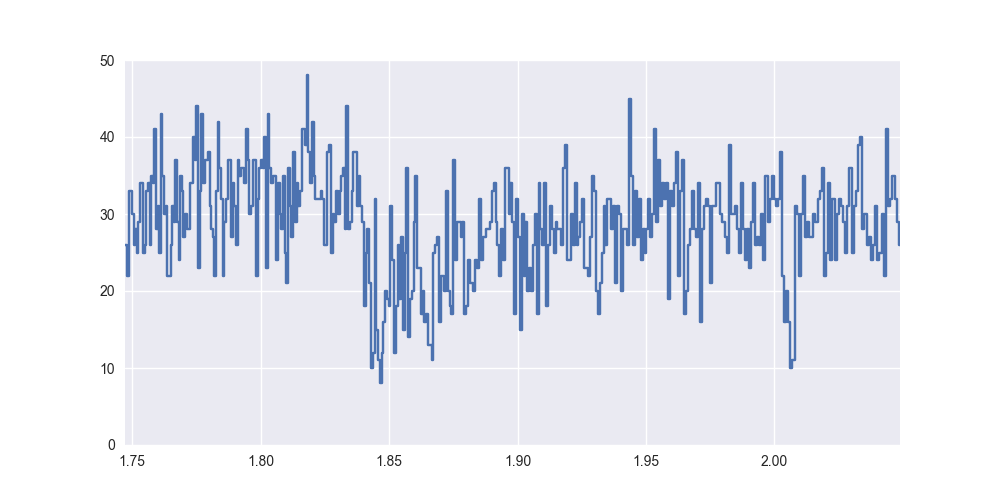

(0, 50)

In [20]:
plt.figure(figsize=(10,5))
plt.plot(bm_small, c_small, linestyle="steps-mid")
plt.xlim(bm_small[0], bm_small[-1])
plt.ylim(0, 50)

Okay, let's convert that into flux space. Let's try to divide the observed spectrum by the ARF:

In [22]:
c_arf = counts/specresp
c_arf_small = c_arf[min_idx:max_idx]

<IPython.core.display.Javascript object>


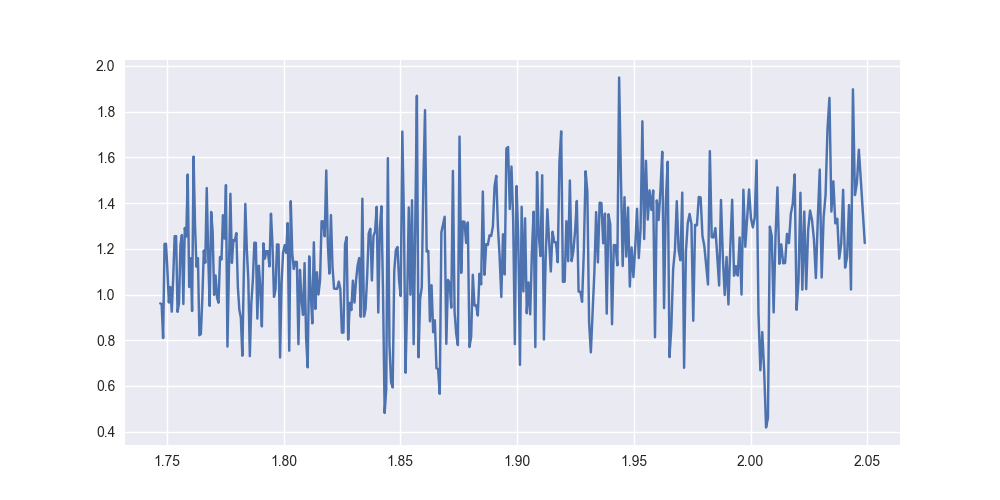

In [23]:
plt.figure(figsize=(10,5))
plt.plot(bm_small, c_arf_small)

## Test 1

In this first test, we're running only the HEG_P spectrum, and we're printing out what the model looks like at every stage in the analysis. 

Let's load the model:

In [77]:
samples = np.loadtxt("../data/tests/test1_posterior_sample.txt")
print("There are %i samples."%len(samples))

There are 423 samples.


What is the distribution of Doppler shifts?

<IPython.core.display.Javascript object>


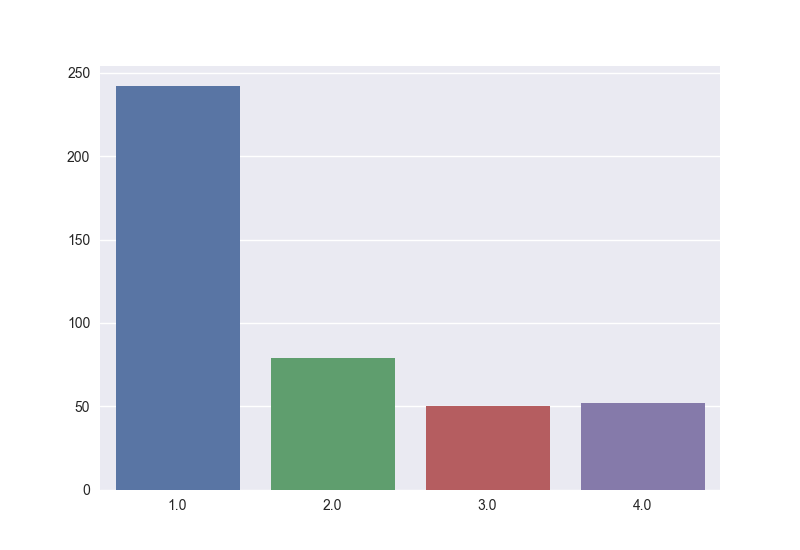

In [78]:
s = pd.Series(samples[:, 10]).value_counts()
plt.figure()
sns.barplot(s.index, s.values)

<IPython.core.display.Javascript object>


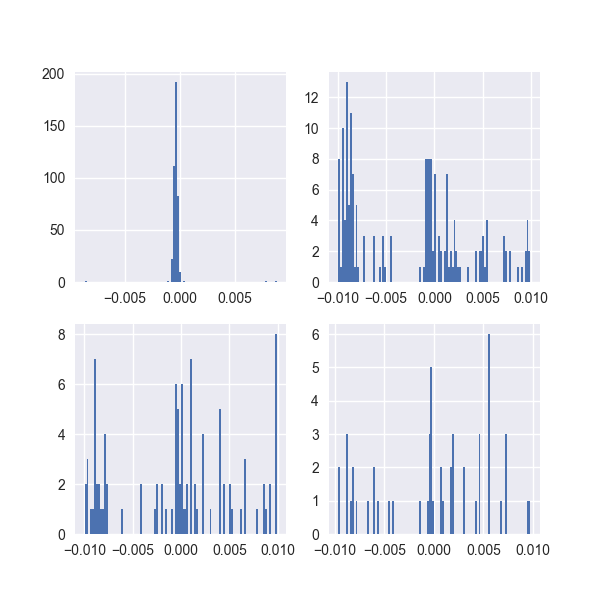

In [79]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6,6))
ax1.hist(samples[samples[:,11]!=0.0,11], bins=100, histtype="stepfilled")
ax2.hist(samples[samples[:,12]!=0.0,12], bins=100, histtype="stepfilled")
ax3.hist(samples[samples[:,13]!=0.0,13], bins=100, histtype="stepfilled")
ax4.hist(samples[samples[:,14]!=0.0,14], bins=100, histtype="stepfilled");
#ax1.hist(samples[:,12], bins=100, histtype="stepfilled")
#ax2.hist(samples[:,13], bins=100, histtype="stepfilled")
#ax3.hist(samples[:,14], bins=100, histtype="stepfilled")
#ax4.hist(samples[:,15], bins=100, histtype="stepfilled");





Let's plot the data and the model together. In order to do that, we're going to need to get the right arrays out of the file. I've stored the model in various forms:
* the lines only
* lines + background
* (lines + background) x ARF
* (lines + background) x ARF x exp(OU process)
* [(lines + background) x ARF x exp(OU process)] convolved with the RMF

In [80]:
len_small = len(c_small)

full_model = samples[:, -len_small:]
model_with_ou = samples[:, -2*len_small:-len_small]
model_with_arf = samples[:, -3*len_small:-2*len_small]
model_with_bkg = samples[:, -4*len_small:-3*len_small]
model_with_lines = samples[:, -5*len_small:-4*len_small]
ou_process = samples[:, -6*len_small:-5*len_small]

Let's plot all of those to see what they look like:

<IPython.core.display.Javascript object>


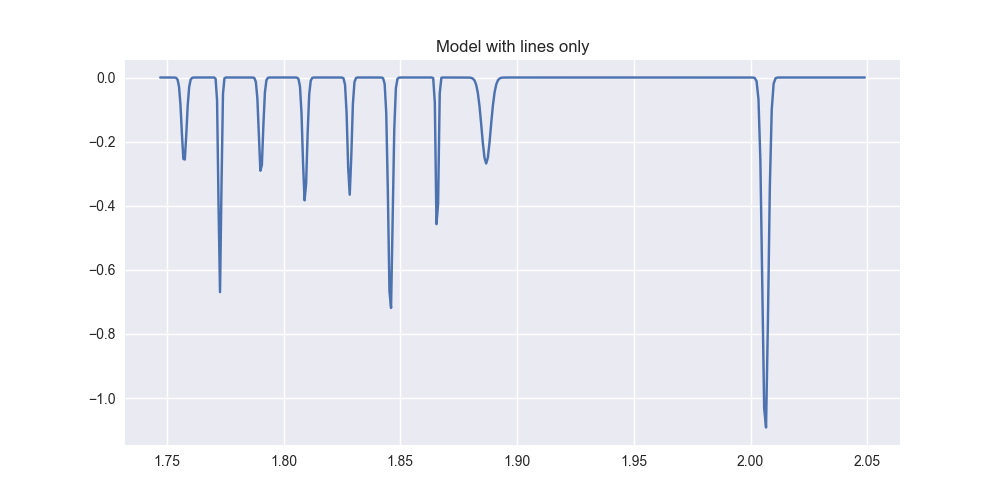

<IPython.core.display.Javascript object>


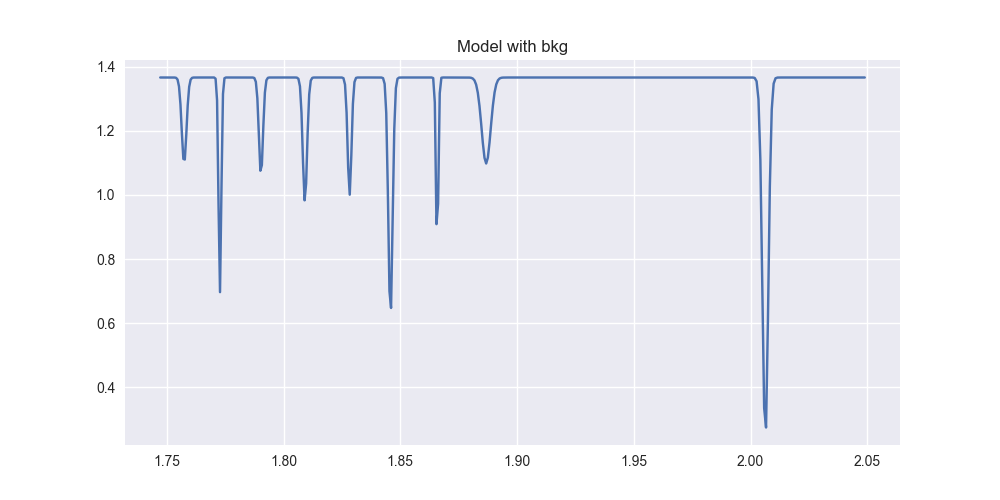

<IPython.core.display.Javascript object>


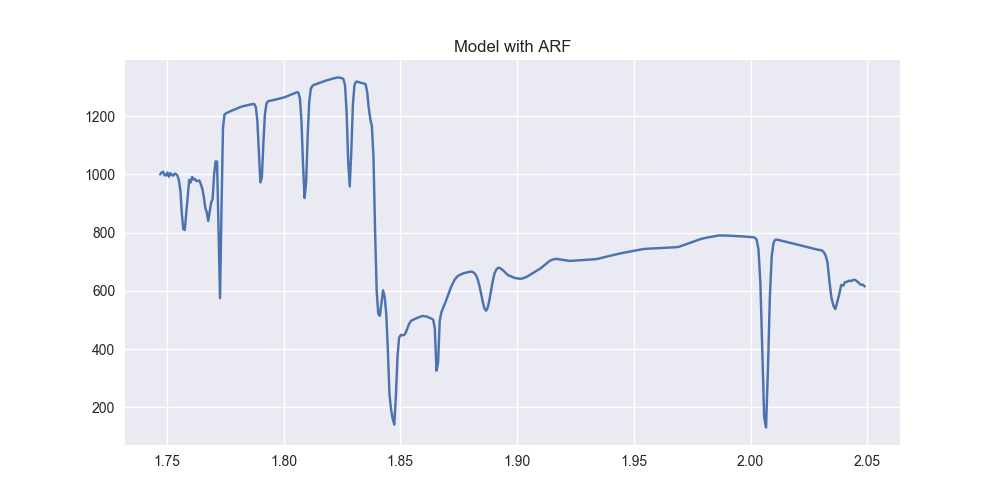

<IPython.core.display.Javascript object>


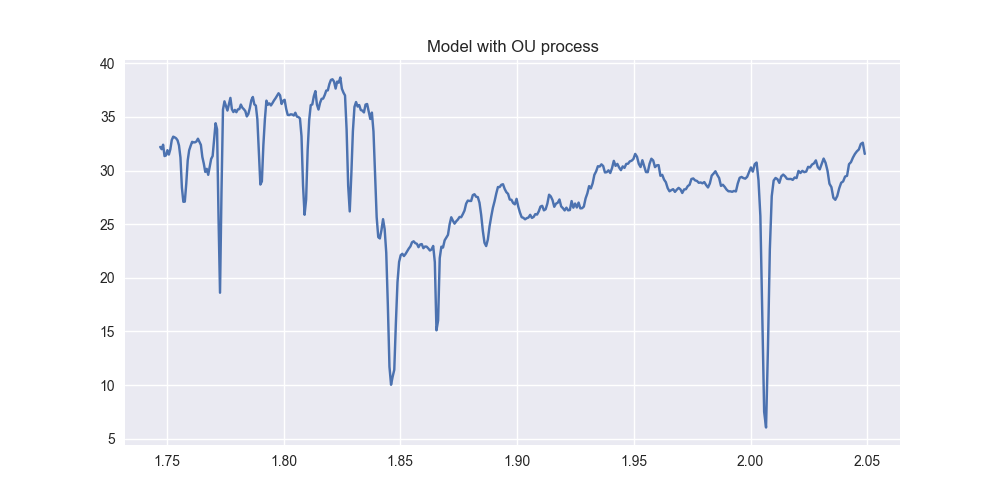

<IPython.core.display.Javascript object>


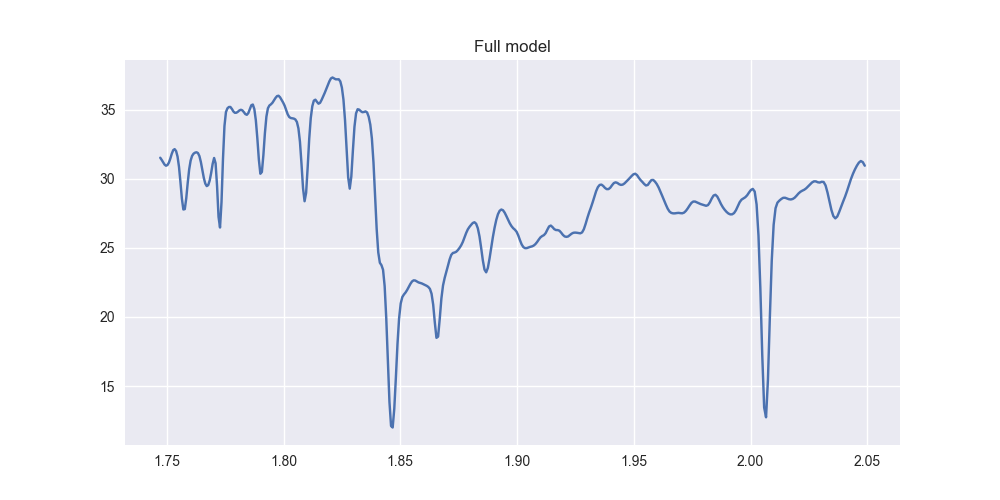

<IPython.core.display.Javascript object>


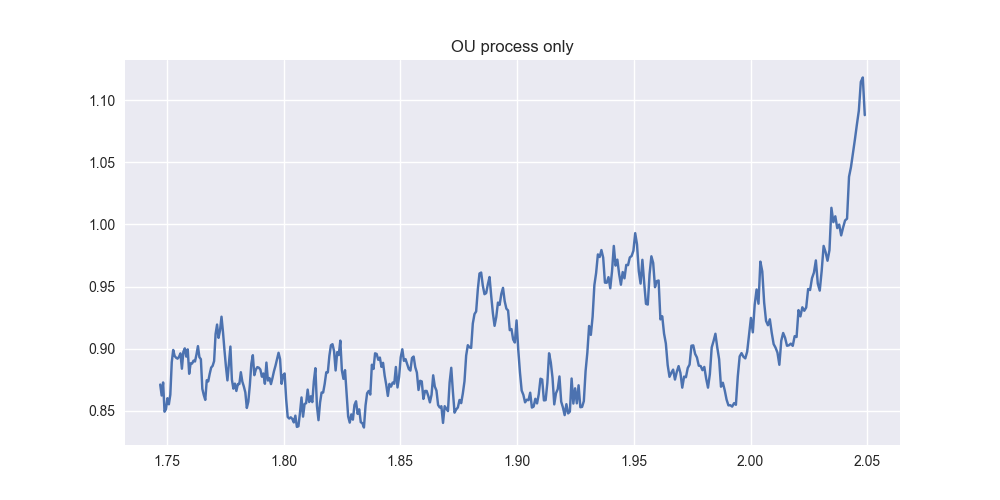

In [101]:
plt.figure(figsize=(10,5))
plt.plot(bm_small, model_with_lines.T[:,:1])
plt.title("Model with lines only")

plt.figure(figsize=(10,5))
plt.plot(bm_small, model_with_bkg.T[:,:1])
plt.title("Model with bkg")

plt.figure(figsize=(10,5))
plt.plot(bm_small, model_with_arf.T[:,:1])
plt.title("Model with ARF")

plt.figure(figsize=(10,5))
plt.plot(bm_small, model_with_ou.T[:,:1])
plt.title("Model with OU process")

plt.figure(figsize=(10,5))
plt.plot(bm_small, full_model.T[:,:1])
plt.title("Full model")

plt.figure(figsize=(10,5))
plt.plot(bm_small, np.exp(ou_process.T[:,:1]))
plt.title("OU process only")

Let's plot the full model against the data:

<IPython.core.display.Javascript object>


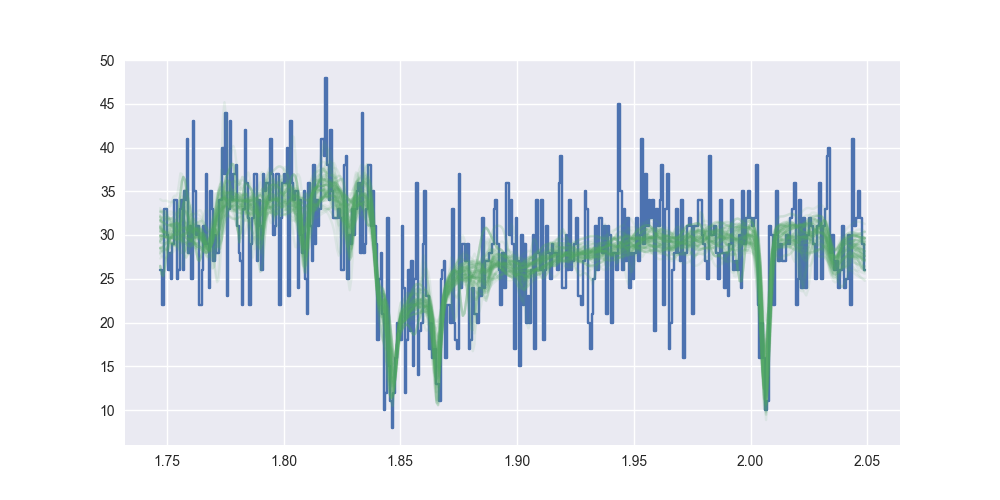

In [57]:
plt.figure(figsize=(10,5))
plt.plot(bm_small, c_small, linestyle="steps-mid")
for f in full_model:
    plt.plot(bm_small, f, c=sns.color_palette()[1], alpha=0.1)

What if I plot the models without ARF and the data divided by the ARF?

<IPython.core.display.Javascript object>


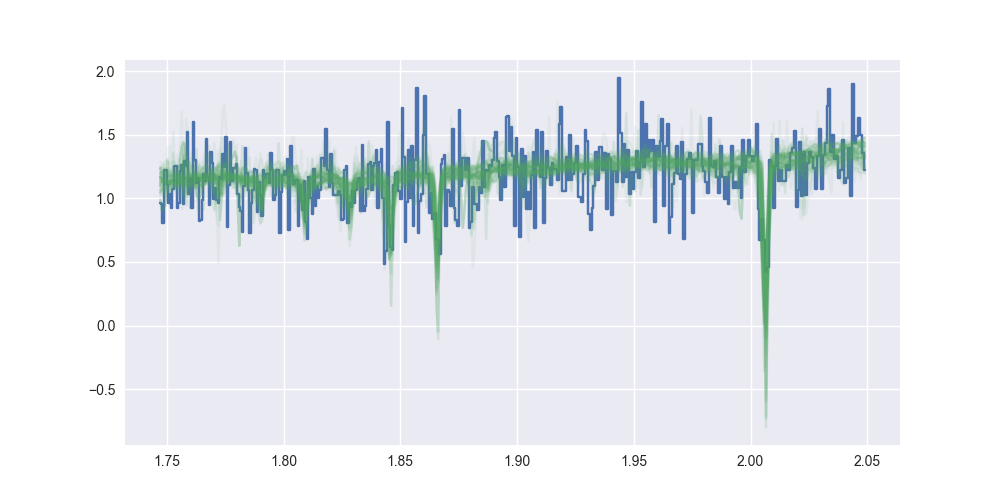

In [62]:
plt.figure(figsize=(10,5))
plt.plot(bm_small, c_arf_small, linestyle="steps-mid")
for f,o in zip(model_with_bkg, ou_process):
    plt.plot(bm_small, f*np.exp(o), alpha=0.08, color=sns.color_palette()[1])

Let's get the sherpa-deconvolved spectrum:

In [109]:
ui.set_source("f0_heg_p1", ui.polynom1d.truespec)
c_deconv = ui.get_ratio_plot("f0_heg_p1").y
e_deconv = ui.get_ratio_plot("f0_heg_p1").x

c_deconv_small = c_deconv[min_idx:max_idx]
e_deconv_small = e_deconv[min_idx:max_idx]

In [111]:
s = ui.get_source("f0_heg_p1")

In [113]:
print(s.c0)

val         = 1.0
min         = -3.40282346639e+38
max         = 3.40282346639e+38
units       = 
frozen      = False
link        = None
default_val = 1.0
default_min = -3.40282346639e+38
default_max = 3.40282346639e+38


<IPython.core.display.Javascript object>


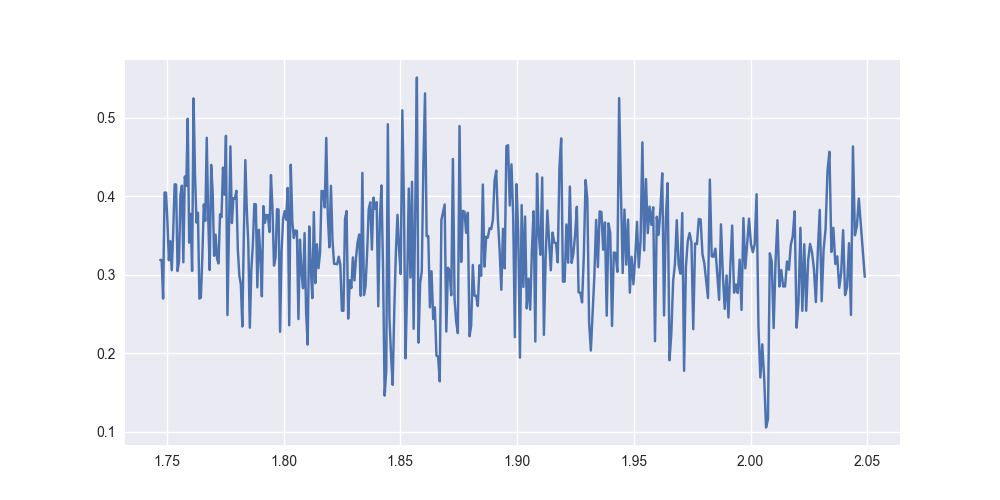

In [84]:
plt.figure(figsize=(10,5))
plt.plot(bm_small, c_deconv_small)

<IPython.core.display.Javascript object>


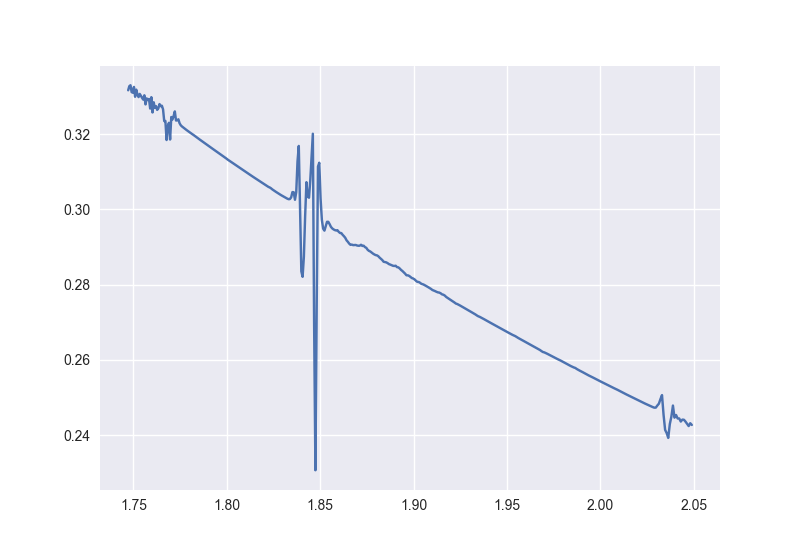

In [85]:
plt.figure()
plt.plot(bm_small, c_deconv_small/c_arf_small)

<IPython.core.display.Javascript object>


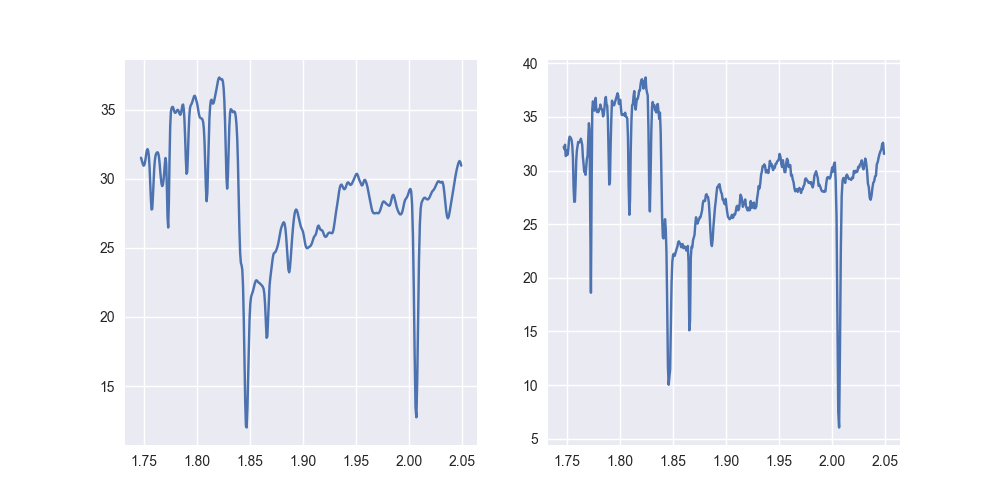

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(bm_small, full_model.T[:,:1])
#plt.ylim(0.0, 0.5)
ax2.plot(bm_small, model_with_ou.T[:,:1] )

## Test 2

I've changed the model so that the line is added to the log of the background. Let's see what that looks like:

In [104]:
samples = np.loadtxt("../data/tests/test2_posterior_sample.txt")
print("There are %i samples."%len(samples))

There are 85 samples.


<IPython.core.display.Javascript object>


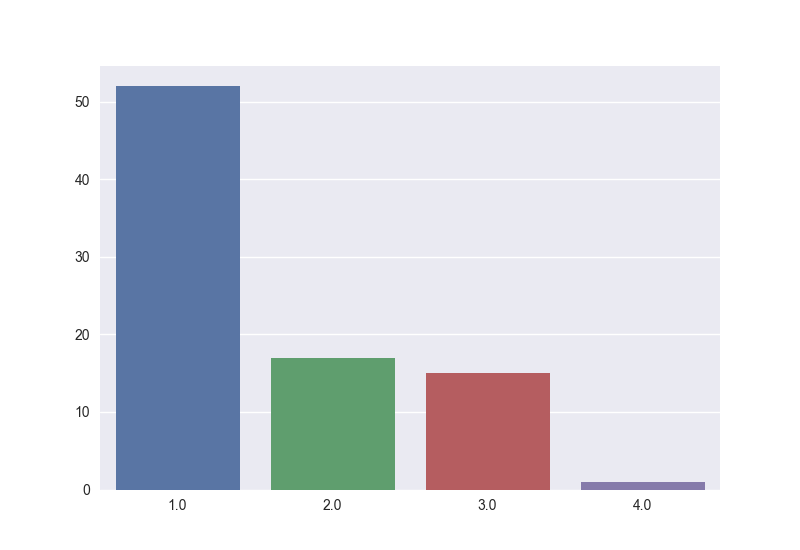

In [105]:
s = pd.Series(samples[:, 10]).value_counts()
plt.figure()
sns.barplot(s.index, s.values)

<IPython.core.display.Javascript object>


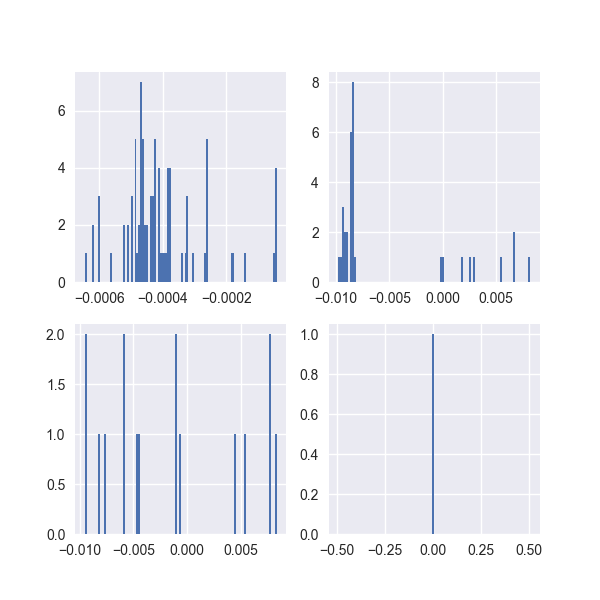

In [106]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6,6))
ax1.hist(samples[samples[:,11]!=0.0,11], bins=100, histtype="stepfilled")
ax2.hist(samples[samples[:,12]!=0.0,12], bins=100, histtype="stepfilled")
ax3.hist(samples[samples[:,13]!=0.0,13], bins=100, histtype="stepfilled")
ax4.hist(samples[samples[:,14]!=0.0,14], bins=100, histtype="stepfilled");

In [107]:
len_small = len(c_small)

full_model = samples[:, -len_small:]
model_with_ou = samples[:, -2*len_small:-len_small]
model_with_arf = samples[:, -3*len_small:-2*len_small]
model_with_bkg = samples[:, -4*len_small:-3*len_small]
model_with_lines = samples[:, -5*len_small:-4*len_small]
ou_process = samples[:, -6*len_small:-5*len_small]

<IPython.core.display.Javascript object>


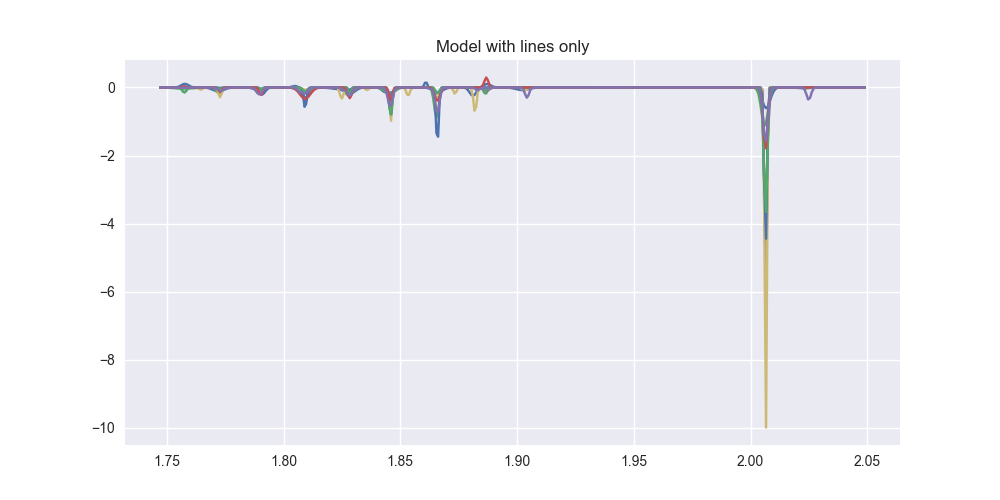

<IPython.core.display.Javascript object>


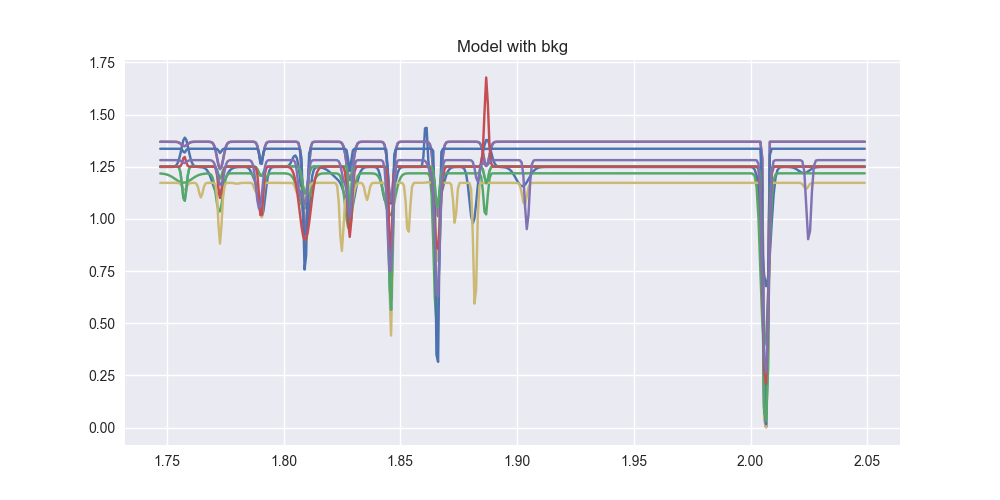

<IPython.core.display.Javascript object>


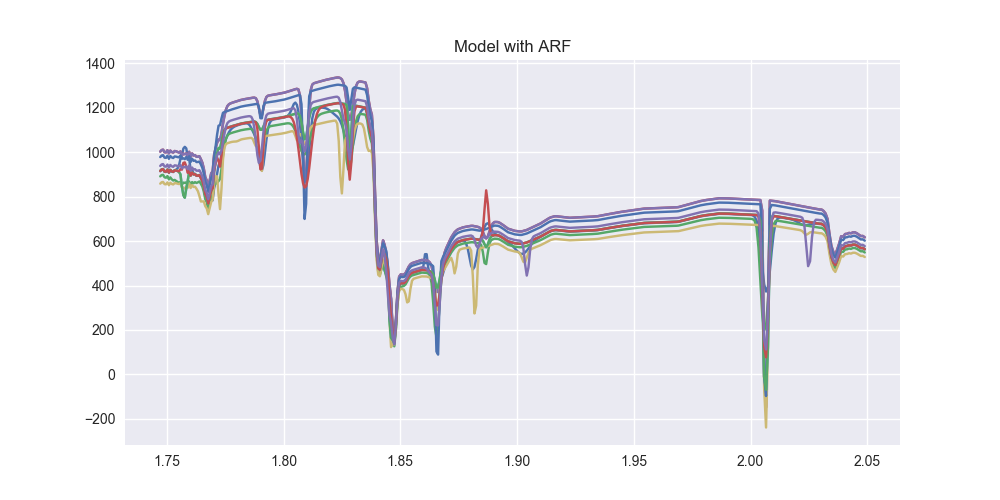

<IPython.core.display.Javascript object>


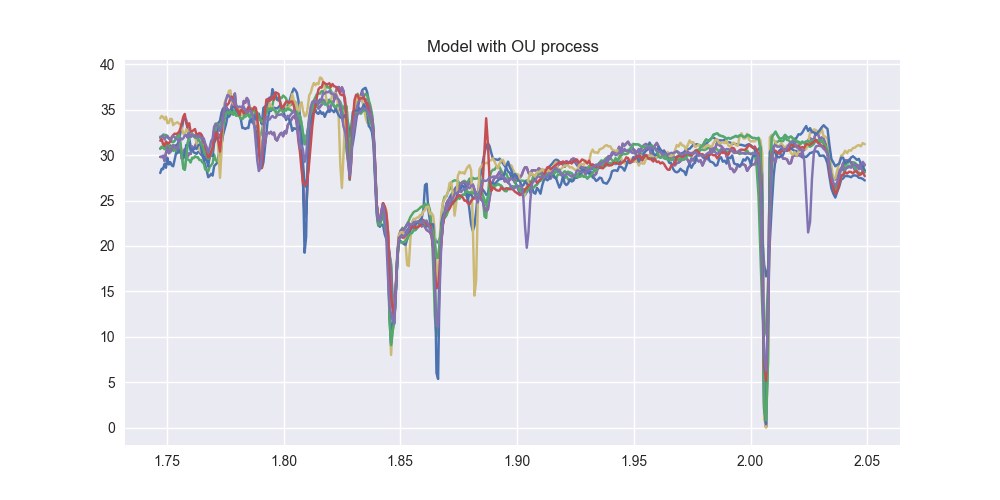

<IPython.core.display.Javascript object>


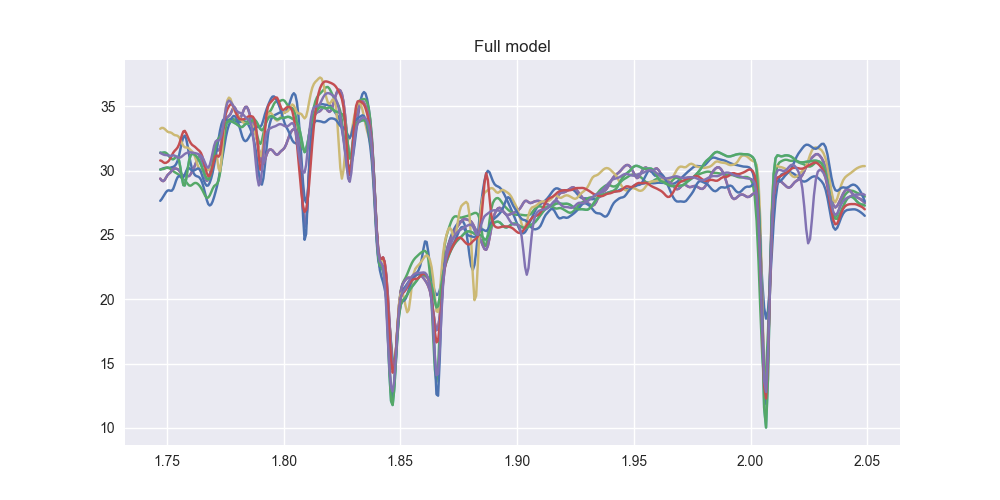

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


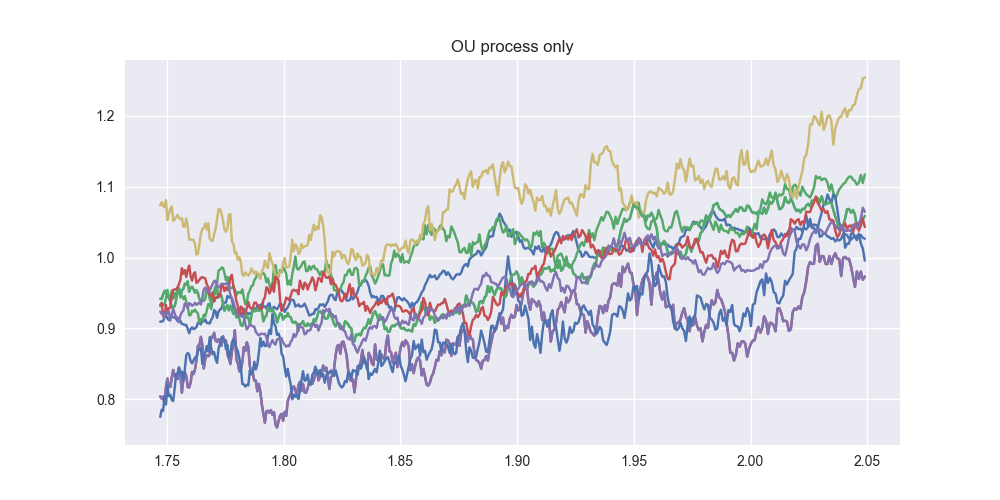

In [114]:
plt.figure(figsize=(10,5))
plt.plot(bm_small, model_with_lines.T[:,-10:])
plt.title("Model with lines only")

plt.figure(figsize=(10,5))
plt.plot(bm_small, model_with_bkg.T[:,-10:])
plt.title("Model with bkg")

plt.figure(figsize=(10,5))
plt.plot(bm_small, model_with_arf.T[:,-10:])
plt.title("Model with ARF")

plt.figure(figsize=(10,5))
plt.plot(bm_small, model_with_ou.T[:,-10:])
plt.title("Model with OU process")

plt.figure(figsize=(10,5))
plt.plot(bm_small, full_model.T[:,-10:])
plt.title("Full model")

plt.figure(figsize=(10,5))
plt.plot(bm_small, np.exp(ou_process.T[:,-10:]))
plt.title("OU process only")

## Test 3

I've turned off the OU process for this one:

In [263]:
samples = np.loadtxt("../data/tests/test3_posterior_sample.txt")
print("There are %i samples."%len(samples))


There are 80 samples.


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


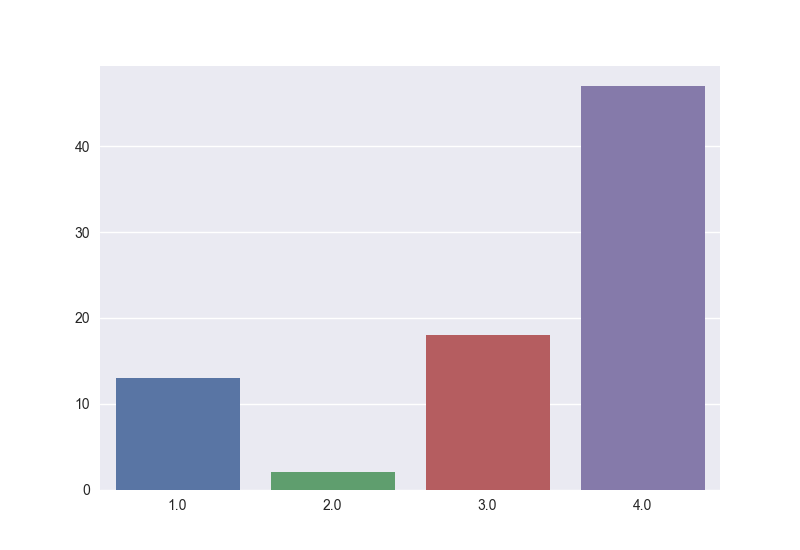

In [264]:
s = pd.Series(samples[:, 10]).value_counts()
plt.figure()
sns.barplot(s.index, s.values)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


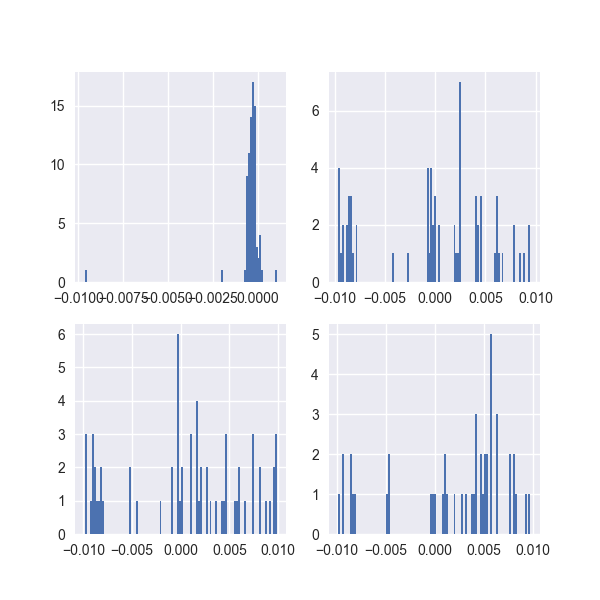

In [234]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6,6))
ax1.hist(samples[samples[:,11]!=0.0,11], bins=100, histtype="stepfilled")
ax2.hist(samples[samples[:,12]!=0.0,12], bins=100, histtype="stepfilled")
ax3.hist(samples[samples[:,13]!=0.0,13], bins=100, histtype="stepfilled")
ax4.hist(samples[samples[:,14]!=0.0,14], bins=100, histtype="stepfilled");

In [235]:
len_small = len(c_small)

full_model = samples[:, -len_small:]
model_with_ou = samples[:, -2*len_small:-len_small]
model_with_arf = samples[:, -3*len_small:-2*len_small]
model_with_bkg = samples[:, -4*len_small:-3*len_small]
model_with_lines = samples[:, -5*len_small:-4*len_small]
ou_process = samples[:, -6*len_small:-5*len_small]

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


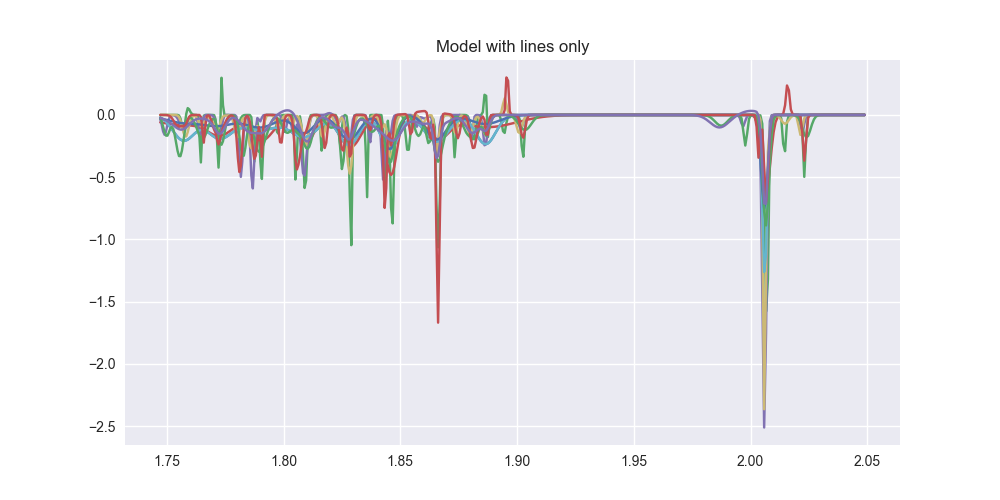

<IPython.core.display.Javascript object>


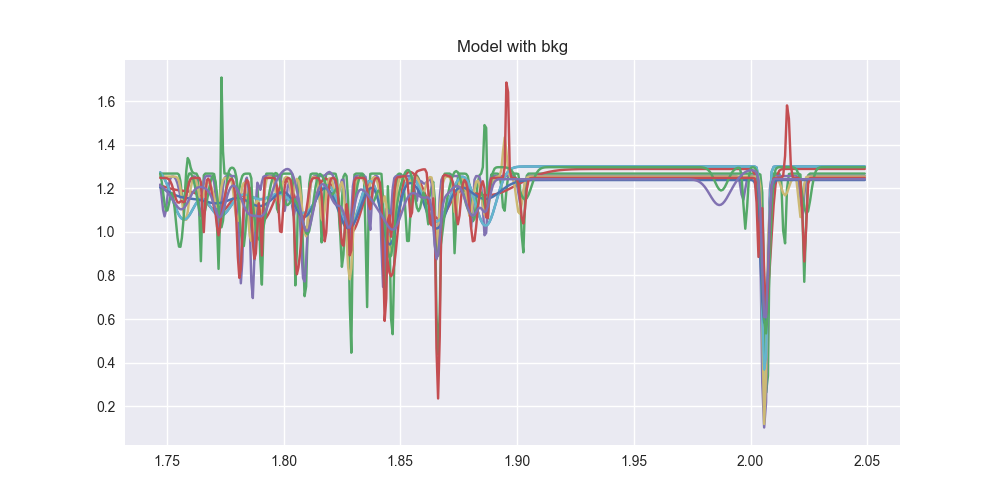

<IPython.core.display.Javascript object>


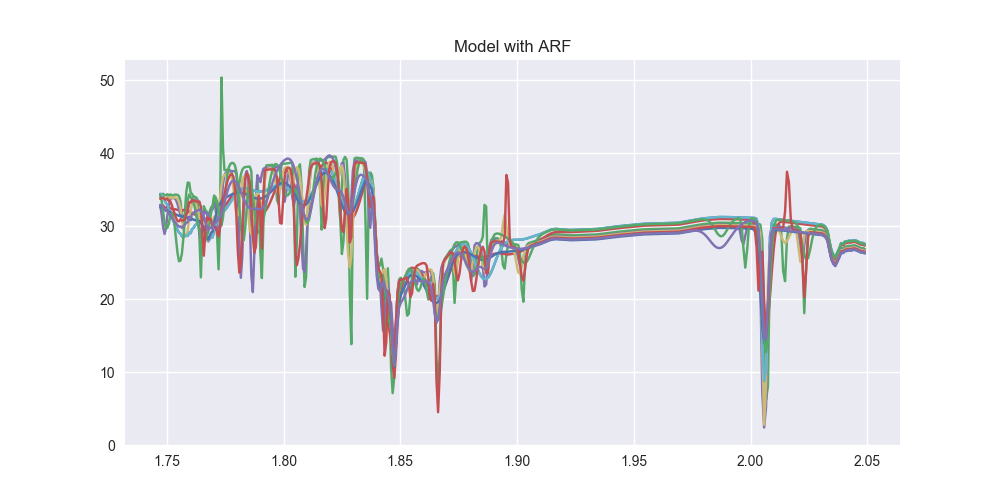

<IPython.core.display.Javascript object>


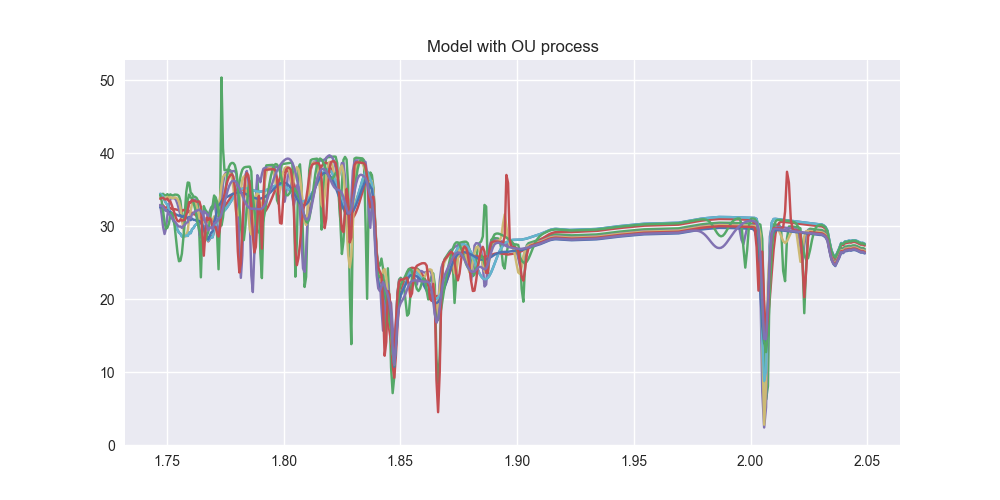

<IPython.core.display.Javascript object>


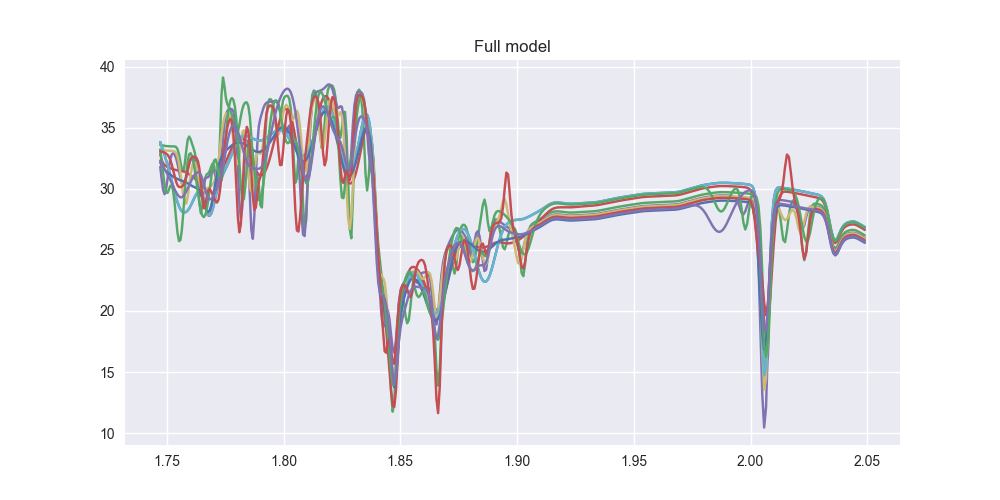

<IPython.core.display.Javascript object>


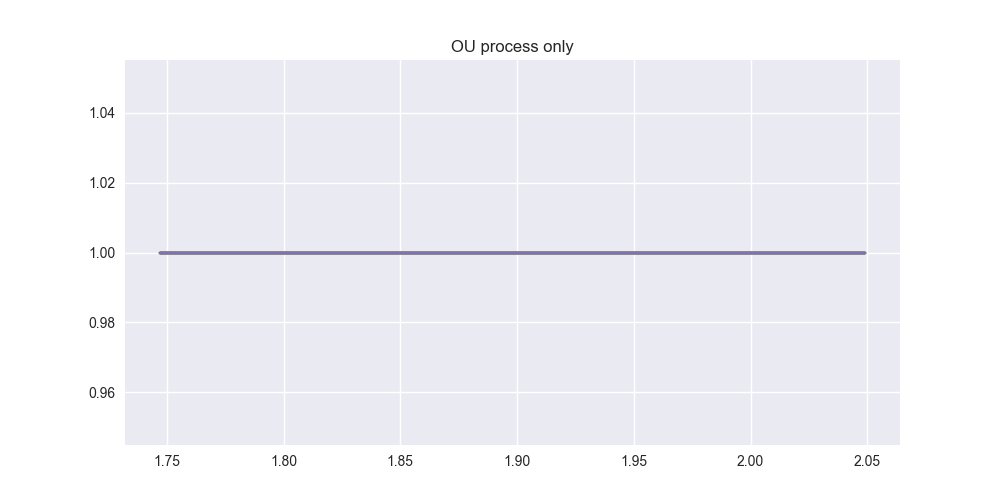

In [236]:
plt.figure(figsize=(10,5))
plt.plot(bm_small, model_with_lines.T[:,-10:])
plt.title("Model with lines only")

plt.figure(figsize=(10,5))
plt.plot(bm_small, model_with_bkg.T[:,-10:])
plt.title("Model with bkg")

plt.figure(figsize=(10,5))
plt.plot(bm_small, model_with_arf.T[:,-10:])
plt.title("Model with ARF")

plt.figure(figsize=(10,5))
plt.plot(bm_small, model_with_ou.T[:,-10:])
plt.title("Model with OU process")

plt.figure(figsize=(10,5))
plt.plot(bm_small, full_model.T[:,-10:])
plt.title("Full model")

plt.figure(figsize=(10,5))
plt.plot(bm_small, np.exp(ou_process.T[:,-10:]))
plt.title("OU process only")

Let's see if we can fold the model through the source RMF using sherpa:

In [237]:
m = model_with_bkg[0,:]

In [238]:
arf = d.get_arf()
rmf = d.get_rmf()

To do this, we'll need to make a zero-padded array of the same length as the rmf:

In [248]:
nchannels = len(bin_lo)
padded_model = np.zeros(nchannels) 
padded_model[min_idx:max_idx] = m
padded_model[:min_idx] = samples[0,0]
padded_model[max_idx:] = samples[0,0]

In [249]:
m_arf = arf.apply_arf(padded_model)
m_arf2 = padded_model * arf.specresp
m_rmf = rmf.apply_rmf(m_arf)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


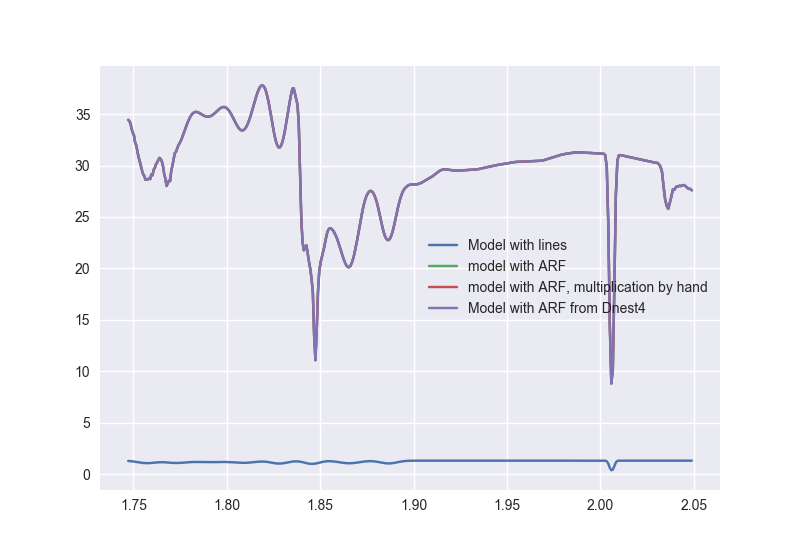

In [250]:
plt.figure()
plt.plot(bm_small, m, label="Model with lines")
plt.plot(bm_small, m_arf[min_idx:max_idx], label="model with ARF")
plt.plot(bm_small, m_arf2[min_idx:max_idx], label="model with ARF, multiplication by hand")
plt.plot(bm_small, model_with_arf[0], label="Model with ARF from Dnest4")
#plt.plot(bm_small, m_rmf[min_idx:max_idx], label="model with ARF + RMF")
#plt.plot(bm_small, full_model[0, :], label="full model from DNest4")
plt.legend()

Let's check whether the model with ARF from DNest4, the model with ARF from Sherpa and the model that I multiplied by the spectral response by hand are the same:

In [260]:
np.allclose(m_arf[min_idx:max_idx], model_with_arf[0])

True

In [261]:
np.allclose(m_arf2[min_idx:max_idx], model_with_arf[0])

True

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


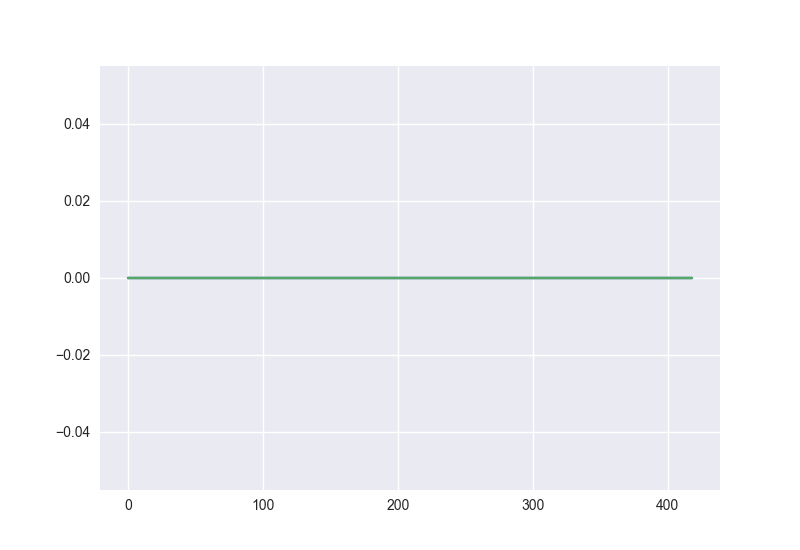

In [262]:
plt.figure()
plt.plot(model_with_arf[0]-m_arf[min_idx:max_idx])
plt.plot(model_with_arf[0]-m_arf2[min_idx:max_idx])

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


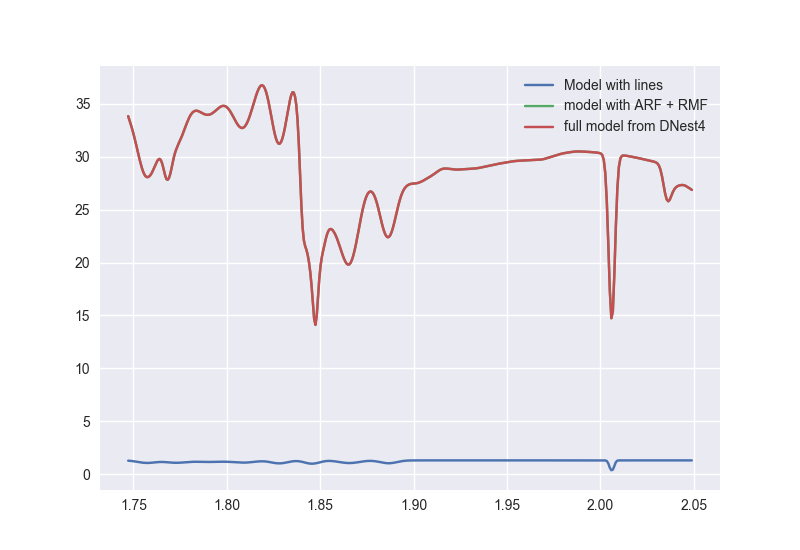

In [252]:
plt.figure()
plt.plot(bm_small, m, label="Model with lines")
#plt.plot(bm_small, m_arf[min_idx:max_idx], label="model with ARF")
#plt.plot(bm_small, model_with_arf[0], label="Model with ARF from Dnest4")
plt.plot(bm_small, m_rmf[min_idx:max_idx], label="model with ARF + RMF")
plt.plot(bm_small, full_model[0, :], label="full model from DNest4")
plt.legend()

In [253]:
nchannels = len(bin_lo)
padded_model = np.zeros(nchannels) + samples[0,0]
padded_model[min_idx:max_idx] = model_with_arf[0]
m_rmf2 = rmf.apply_rmf(padded_model)

In [265]:
np.allclose(m_rmf[min_idx:max_idx], full_model[0])

True

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


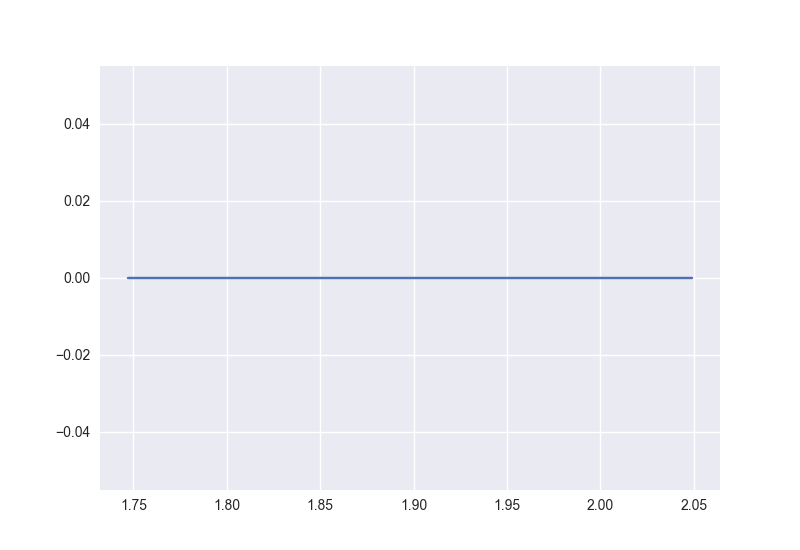

In [254]:
plt.figure()
plt.plot(bm_small, m_rmf[min_idx:max_idx]-full_model[0])

It all works! The response operations are correct! :-) :-) :-)